In [6]:
import pandas as pd
import numpy as np
dfCC = pd.read_csv('./procST4.csv')
returnMat = dfCC.to_numpy()
returnMat = returnMat[:,1:]
returnMat = returnMat.T
meanVecNP = returnMat.mean(axis=1)
covMatrix = np.cov(returnMat,bias=True)

In [7]:
from numpy import linalg as la

def nearestPD(A):
    B = (A + A.T) / 2
    _, s, V = la.svd(B)
    H = np.dot(V.T, np.dot(np.diag(s), V))
    A2 = (B + H) / 2
    A3 = (A2 + A2.T) / 2
    if isPD(A3):
        return A3
    spacing = np.spacing(la.norm(A))
    I = np.eye(A.shape[0])
    k = 1
    while not isPD(A3):
        mineig = np.min(np.real(la.eigvals(A3)))
        A3 += I * (-mineig * k**2 + spacing)
        k += 1
    return A3

def isPD(B):
    try:
        _ = la.cholesky(B)
        return True
    except la.LinAlgError:
        return False

In [8]:
# CVaR
from gurobipy import Model,GRB
m = Model("CVaR")
m.setParam('OutputFlag', 0)
epsl = .01
alpha = .1
constant = 1/(1-alpha)
meanVec = meanVecNP.tolist()
covMatPSD = nearestPD(covMatrix).tolist()
returnMat_list = returnMat.tolist()
numAsset = len(meanVec)
numPeriod = len(returnMat_list[0])
x = m.addVars(numAsset,lb=0,ub=1, name="x") # x_j_k
y = m.addVars(numAsset, name="y")
eta = m.addVar(lb=-1000000000)
m.setObjective(eta + constant*sum(y[i] for i in range(numAsset)), GRB.MINIMIZE)
for i in range(numAsset):
    m.addConstr(y[i] >= -sum(x[i]*returnMat_list[i][j] for j in range(numPeriod)) - eta)
m.addConstr(sum(x[i] for i in range(numAsset)) <= 1)
m.addConstr(sum(x[i] for i in range(numAsset)) >= 1-epsl)
m.update()

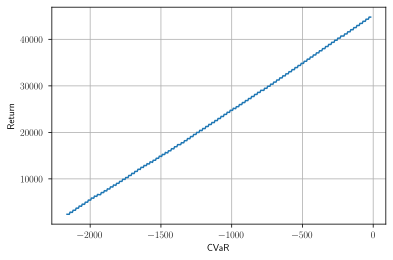

In [9]:
MinTarget = [i for i in range(5000,45000,100)]
risk_data = np.zeros(len(MinTarget))
ret_data = np.zeros(len(MinTarget))
count_divers = np.zeros(len(MinTarget))
dfExp = pd.DataFrame()
for j in range(len(MinTarget)):
#     print(MinTarget[j])
    m.addConstr(sum(x[i]*meanVec[i] for i in range(numAsset)) >= MinTarget[j],'BudgetConstr')
    try:
        m.optimize()
        Invest = m.getAttr('x',x)
        CVaR = m.objVal
        m.remove(m.getConstrByName('BudgetConstr'))
        m.update()
        risk_data[j] = CVaR
        investNP = np.array(Invest.values())
        ret_data[j] = meanVecNP.T.dot(np.round(investNP,2))
        count_divers[j] = np.sum(np.array(investNP) > .001, axis=0)
        dfExp[str(MinTarget[j]) +"_"+ str(np.round(CVaR))] = np.round(investNP,3)
    except:
        break
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure()
plt.rc('text', usetex=True)
ax = fig.add_subplot(111)
plt.plot(risk_data[1:], ret_data[1:])
plt.xlabel('CVaR')
plt.ylabel('Return')
plt.grid()
plt.savefig("dfCVaR_return_risk.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()
del m

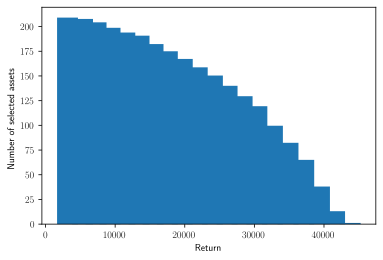

In [10]:
ret_data_bin = np.mean(np.stack( np.array_split(ret_data, 20), axis=0 ),axis=1)
count_divers_bin = np.mean(np.stack( np.array_split(count_divers, 20), axis=0 ),axis=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig = plt.figure()
ax = fig.add_subplot(111)
plt.rc('text', usetex=True)
plt.bar(ret_data_bin , count_divers_bin,3000)
plt.xlabel('Return')
plt.ylabel('Number of selected assets')
plt.savefig("dfCVaR_diversity.pdf", bbox_inches = 'tight',pad_inches = 0)
plt.show()

In [11]:
dfExp.to_csv("dfCVaR.csv")